In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
directory = 'C:\GitHub\Datathon2023\data\Driver Drowsiness Dataset (DDD)'

BATCH_SIZE = 128
IMG_SIZE = (64, 64)

train_dataset = image_dataset_from_directory(
    directory,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.125,
    subset='training',
    seed=42
)

validation_dataset = image_dataset_from_directory(
    directory,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.125,
    subset='validation',
    seed=42
)

<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\stlso\AppData\Local\Temp\ipykernel_2808\3845701359.py:1: SyntaxWarning: invalid escape sequence '\G'
  directory = 'C:\GitHub\Datathon2023\data\Driver Drowsiness Dataset (DDD)'


Found 41793 files belonging to 2 classes.
Using 36569 files for training.
Found 41793 files belonging to 2 classes.
Using 5224 files for validation.


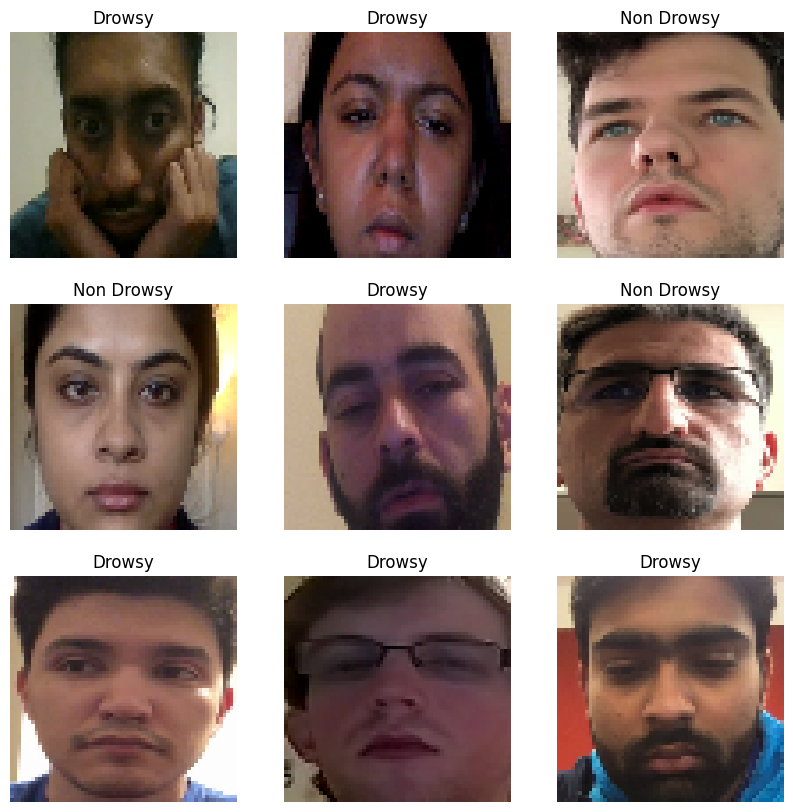

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
from tensorflow.keras.layers import RandomContrast, RandomBrightness, Rescaling, RandomFlip

def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomContrast(0.1))
    data_augmentation.add(RandomBrightness(0.2))
    # data_augmentation.add(Rescaling(1./255, input_shape=(224, 224, 3)))
    data_augmentation.add(RandomFlip("horizontal"))
    return data_augmentation

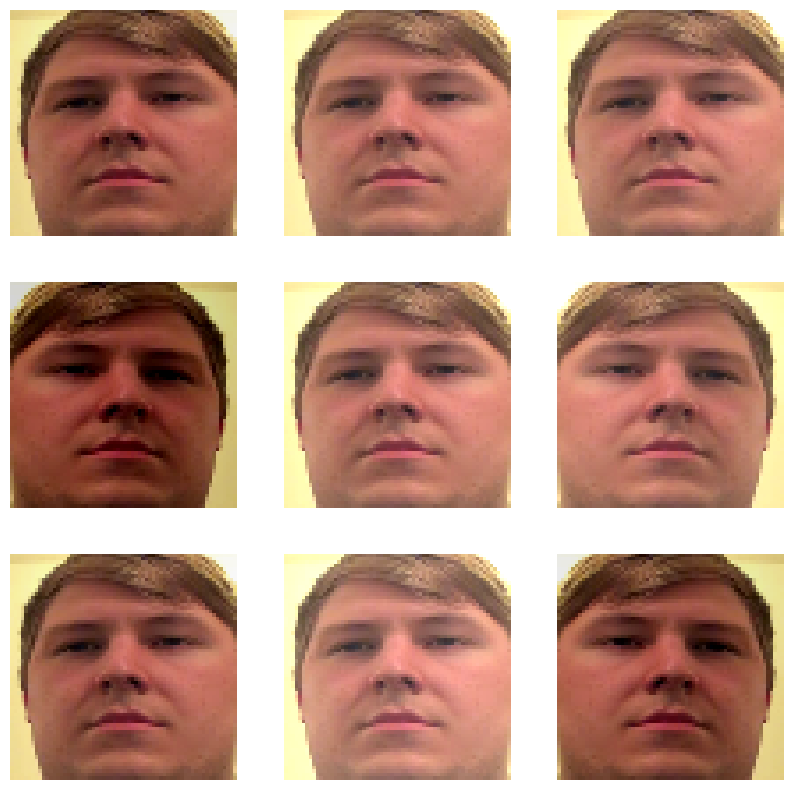

In [5]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [6]:
def normalize(image, label):
    return image / 255.0, label

train_dataset = train_dataset.map(normalize)
validation_dataset = validation_dataset.map(normalize)

In [7]:
for images, labels in train_dataset.take(1):
    print("Pixel value range after normalization:", tf.reduce_min(images), tf.reduce_max(images))

Pixel value range after normalization: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [8]:
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model

def identity_block(X, f, filters, initializer=random_uniform):
    F1, F2, F3 = filters
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    # X = Dropout(dropout_rate)(X)
    
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X) 

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) 
    
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

In [9]:
def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform, dropout_rate=0.4):   
    F1, F2, F3 = filters
    X_shortcut = X


    ##### MAIN PATH #####
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = Dropout(dropout_rate)(X)
    
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    
    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [10]:
def ResNet50(input_shape = (64, 64, 3), training=False, dropout_rate=0.2):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1, dropout_rate=dropout_rate)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2, dropout_rate=dropout_rate)
    
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2, dropout_rate=dropout_rate)
    
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = AveragePooling2D((2,2))(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', kernel_initializer = glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X)

    return model

In [11]:
# tf.keras.backend.set_learning_phase(True)

model = ResNet50(input_shape = (64, 64, 3), training=True, dropout_rate=0.2)
# print(model.summary())

In [12]:
np.random.seed(1)
tf.random.set_seed(2)
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
def dataset_to_numpy(dataset):
    images, labels = [], []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

X_train, Y_train = dataset_to_numpy(train_dataset)
X_val, Y_val = dataset_to_numpy(validation_dataset)

In [14]:
train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(tf.data.AUTOTUNE)
initial_epochs = 5

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, batch_size=BATCH_SIZE)

Epoch 1/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.9214 - loss: 0.2610 - val_accuracy: 0.3513 - val_loss: 5.2589
Epoch 2/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 483s 2s/step - accuracy: 0.9931 - loss: 0.0397 - val_accuracy: 0.9845 - val_loss: 0.0662
Epoch 3/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step - accuracy: 0.9983 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 2.6660e-05
Epoch 4/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - accuracy: 0.9991 - loss: 0.0029 - val_accuracy: 0.7159 - val_loss: 1.4024
Epoch 5/5
286/286 ━━━━━━━━━━━━━━━━━━━━ 576s 2s/step - accuracy: 0.9976 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 3.2644e-06


In [15]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 418ms/step - accuracy: 1.0000 - loss: 7.2438e-06
Validation Loss: 0.0000, Validation Accuracy: 1.0000
